# Классификация текстов (спам/не спам)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from unidecode import unidecode

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix, hstack
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

SEED = 66

In [2]:
data = pd.read_csv("Task_1_original_data.csv")
data

,class,date,from,to,subject,body
0,0,2002-03-15T17:06:22,info@global-change.com,michelle.lokay@enron.com,Next Wave of Energy Trading,Energy Industry Professional: Global Change...
1,0,2002-01-29T11:16:35,info@pmaconference.com,michelle.lokay@enron.com,Register for the Next TXU Capacity Auction!,Register for the next TXU Energy Capacity Auct...
2,0,2002-01-27T22:06:53,info@pmaconference.com,michelle.lokay@enron.com,Merchant Power Monthly Free Sample,.................................................
3,0,2002-03-14T07:22:17,bruno@firstconf.com,energynews@fc.ease.lsoft.com,"t,h: Eyeforenergy Update",Welcome to this week's Eyeforenergy Update. J...
4,0,2002-03-05T03:51:53,deanrogers@energyclasses.com,michelle.lokay@enron.com,"Derivatives Early Bird 'til March 11, Houston",Derivatives For Energy Professionals Two Ful...
...,...,...,...,...,...,...
31710,1,2004-06-24T04:51:30,jacob rzucidlo <lavoneaker@stalag13.com>,johnny wynott <varou@iit.demokritos.gr>,Cpu PAIN M.edICATI0N... SHIPPED to Your D00R !,\n\n arrghh wests amnstv amlsmith basus\n ...
31711,1,2004-06-19T23:52:54,hal leake <annettgaskell@buglover.net>,renato mooney <sigletos@iit.demokritos.gr>,Dn trouble f.r.ee,\n\n\n\n\nDn trouble f.r.ee\n\n\n\nangiospasm ...
31712,1,2004-06-30T06:07:33,dr collins khumalo <khumalo_20@sunumail.sn>,khumalo_20@sunumail.sn,Dr.Collins Khumalo.,\n\n\n\n\nDr.Collins Khumalo.\n\n\n\n\n\n\n\n\...
31713,1,2004-10-10T12:00:18,Customer Support <support@citibank.com>,Paliourg <paliourg@iit.demokritos.gr>,Dear customer your details have been compromised,\n\n\n\n\nDear customer your details have been...


### Предварительный анализ данных

Набор данных включает в себя 31715 объетов, 5 атрибутов данных и 1 целевую переменную.

Всего 5 атрибутов данных:
1. **date** - интервальный признак, дата отправления письма
2. **from** - категориальный признак, отправитель письма
3. **to** - категориальный признак, получатель письма
4. **subject** - категориальный признак, тема письма
5. **body** - категориальный признак, содержание письма

In [3]:
data['date'] = pd.to_datetime(data['date'], errors='coerce', format='%Y-%m-%dT%H:%M:%S')
data.rename(columns = {'class' : 'target'}, inplace = True) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31715 entries, 0 to 31714
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   target   31715 non-null  int64         
 1   date     31561 non-null  datetime64[ns]
 2   from     31702 non-null  object        
 3   to       31048 non-null  object        
 4   subject  31420 non-null  object        
 5   body     31709 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.5+ MB


Данные содержат пропуски, поэтому необходимо произвести обработку пропущенных значений

In [4]:
data.isnull().sum()

target       0
date       154
from        13
to         667
subject    295
body         6
dtype: int64

Удалим строки, где не указана дата. Данные с пропущенным получателем, отправителем, темой и телом письма оставим

In [5]:
data.dropna(axis=0, how='any', subset=['date'], inplace=True)
data.isnull().sum()

target       0
date         0
from         2
to         656
subject    283
body         6
dtype: int64

### Изучение, обработка и генерация признаков

#### Обработка тела письма

In [6]:
# Объдинение темы и тела письма
data['content'] = data['subject'] + ' ' + data['body']

In [7]:
# Удаление url ссылок
data['content'] = data['content'].str.lower().replace(r'\b[a-z]*:\/{2}\S*\s*', '', regex=True)
# Удаление email адресов
data['content'] = data['content'].str.lower().replace(r'[^@\s]+@[^@\s]+\.[^@\s]+', '', regex=True)

In [8]:
nltk.download('stopwords')
nltk.download('wordnet')

wnl = WordNetLemmatizer()
ps = PorterStemmer()
    
def preprocess(text):
    result = []
    
    # Преобразование текста в ASCII
    # Преобразование текста в нижний регистр и разбиение на токены
    tokens = word_tokenize(unidecode(str(text)).lower())
    
    # Токен состоит из букв и не является стоп-словом
    # Лемматизация и стемминг токена
    for token in tokens:
        if str.isalpha(token) and token not in stopwords.words('english'):
            result.append(ps.stem(wnl.lemmatize(token)))
    return ' '.join(result)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Alexey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Alexey\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
%%time
need_preprocess_text = False
if need_preprocess_text:
    data['clean_content'] = data.apply(lambda row: preprocess(row['content']), axis=1)
    data.to_csv("clean_email.csv", index=False)
    data

Wall time: 0 ns


#### Генерация признаков

* Добавим признак, который отображает сколько писем пользователь отправил за час

In [10]:
data = pd.read_csv("clean_email.csv")
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%dT%H:%M:%S')

def date_transform(date):
    return datetime(date.year, date.month, date.day, date.hour)
    
data['date_hour'] = data.apply(lambda row: date_transform(row['date']), axis=1)
data_mail_per_hour = data.groupby(['from', 'date_hour'], as_index=False)['content'].count()
data = pd.merge(data, data_mail_per_hour, on=['from', 'date_hour'])
data.rename(columns = {'content_x' : 'content', 'content_y' : 'mail_per_hour'}, inplace = True) 
data

,target,date,from,to,subject,body,content,clean_content,date_hour,mail_per_hour
0,0,2002-03-15 17:06:22,info@global-change.com,michelle.lokay@enron.com,Next Wave of Energy Trading,Energy Industry Professional: Global Change...,next wave of energy trading energy industry p...,next wave energi trade energi industri profess...,2002-03-15 17:00:00,1
1,0,2002-01-29 11:16:35,info@pmaconference.com,michelle.lokay@enron.com,Register for the Next TXU Capacity Auction!,Register for the next TXU Energy Capacity Auct...,register for the next txu capacity auction! re...,regist next txu capac auction regist next txu ...,2002-01-29 11:00:00,1
2,0,2002-01-27 22:06:53,info@pmaconference.com,michelle.lokay@enron.com,Merchant Power Monthly Free Sample,.................................................,merchant power monthly free sample ............,merchant power monthli free sampl merchant pow...,2002-01-27 22:00:00,1
3,0,2002-03-14 07:22:17,bruno@firstconf.com,energynews@fc.ease.lsoft.com,"t,h: Eyeforenergy Update",Welcome to this week's Eyeforenergy Update. J...,"t,h: eyeforenergy update welcome to this week'...",h eyeforenergi updat welcom week eyeforenergi ...,2002-03-14 07:00:00,1
4,0,2002-03-05 03:51:53,deanrogers@energyclasses.com,michelle.lokay@enron.com,"Derivatives Early Bird 'til March 11, Houston",Derivatives For Energy Professionals Two Ful...,"derivatives early bird 'til march 11, houston ...",deriv earli bird march houston deriv energi pr...,2002-03-05 03:00:00,1
...,...,...,...,...,...,...,...,...,...,...
31554,1,2004-06-24 04:51:30,jacob rzucidlo <lavoneaker@stalag13.com>,johnny wynott <varou@iit.demokritos.gr>,Cpu PAIN M.edICATI0N... SHIPPED to Your D00R !,\n\n arrghh wests amnstv amlsmith basus\n ...,cpu pain m.edicati0n... shipped to your d00r !...,cpu pain ship arrghh west amnstv amlsmith basu...,2004-06-24 04:00:00,1
31555,1,2004-06-19 23:52:54,hal leake <annettgaskell@buglover.net>,renato mooney <sigletos@iit.demokritos.gr>,Dn trouble f.r.ee,\n\n\n\n\nDn trouble f.r.ee\n\n\n\nangiospasm ...,dn trouble f.r.ee \n\n\n\n\ndn trouble f.r.ee\...,dn troubl dn troubl angiospasm zekauska anarti...,2004-06-19 23:00:00,1
31556,1,2004-06-30 06:07:33,dr collins khumalo <khumalo_20@sunumail.sn>,khumalo_20@sunumail.sn,Dr.Collins Khumalo.,\n\n\n\n\nDr.Collins Khumalo.\n\n\n\n\n\n\n\n\...,dr.collins khumalo. \n\n\n\n\ndr.collins khuma...,khumalo khumalo attn presid collin khumalo dir...,2004-06-30 06:00:00,1
31557,1,2004-10-10 12:00:18,Customer Support <support@citibank.com>,Paliourg <paliourg@iit.demokritos.gr>,Dear customer your details have been compromised,\n\n\n\n\nDear customer your details have been...,dear customer your details have been compromis...,dear custom detail compromis dear custom detai...,2004-10-10 12:00:00,1


* Добавим признак, который отображает количество токенов в письме

In [11]:
data['token_count'] = data['clean_content'].apply(lambda x: len(str(x).split()))

* Добавим признак, который отображает день недели

In [12]:
def get_day_week(date):
    return datetime(date.year, date.month, date.day, date.hour)

data['day_week'] = data.apply(lambda row: row['date'].weekday(), axis=1)

* Добавим признак, который отображает временной промежуток, в которое было отправлено письмо

In [13]:
def get_time_period(date):
    hour = date.hour
    if 0 <= hour < 3:
        return 0
    elif 3 <= hour < 6:
        return 1
    elif 6 <= hour < 9:
        return 2
    elif 9 <= hour < 12:
        return 3
    elif 12 <= hour < 15:
        return 4
    elif 15 <= hour < 18:
        return 5
    elif 18 <= hour < 21:
        return 6
    else:
        return 7

data['time_period'] = data.apply(lambda row: get_time_period(row['date']), axis=1)

* Добавим признак, который отображает наличие темы письма

In [14]:
data['have_subject'] = data['subject'].apply(lambda x: 0 if pd.isnull(x) else 1)

* Добавим признак, который показывает пустое ли письмо

In [15]:
data['have_body'] = data['body'].apply(lambda x: 0 if pd.isnull(x) else 1)

#### Анализ признаков

* Распределение целевого класса

<AxesSubplot:xlabel='target', ylabel='count'>

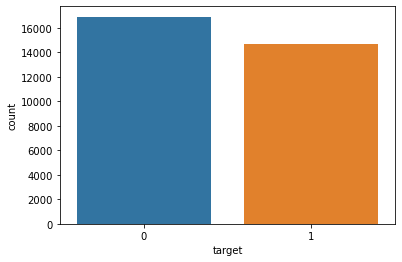

In [16]:
sns.countplot(x='target', data=data)

* Распределение количества отправленных за час писем

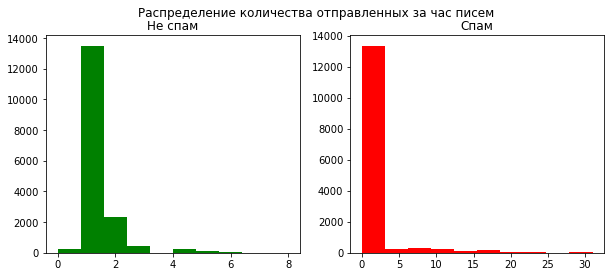

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(data[data['target'] == 0]['mail_per_hour'], color='green')
ax1.set_title('Не спам')
ax2.hist(data[data['target'] == 1]['mail_per_hour'], color='red')
ax2.set_title('Спам')
fig.suptitle('Распределение количества отправленных за час писем')
plt.show()

* Распределение токенов в письме

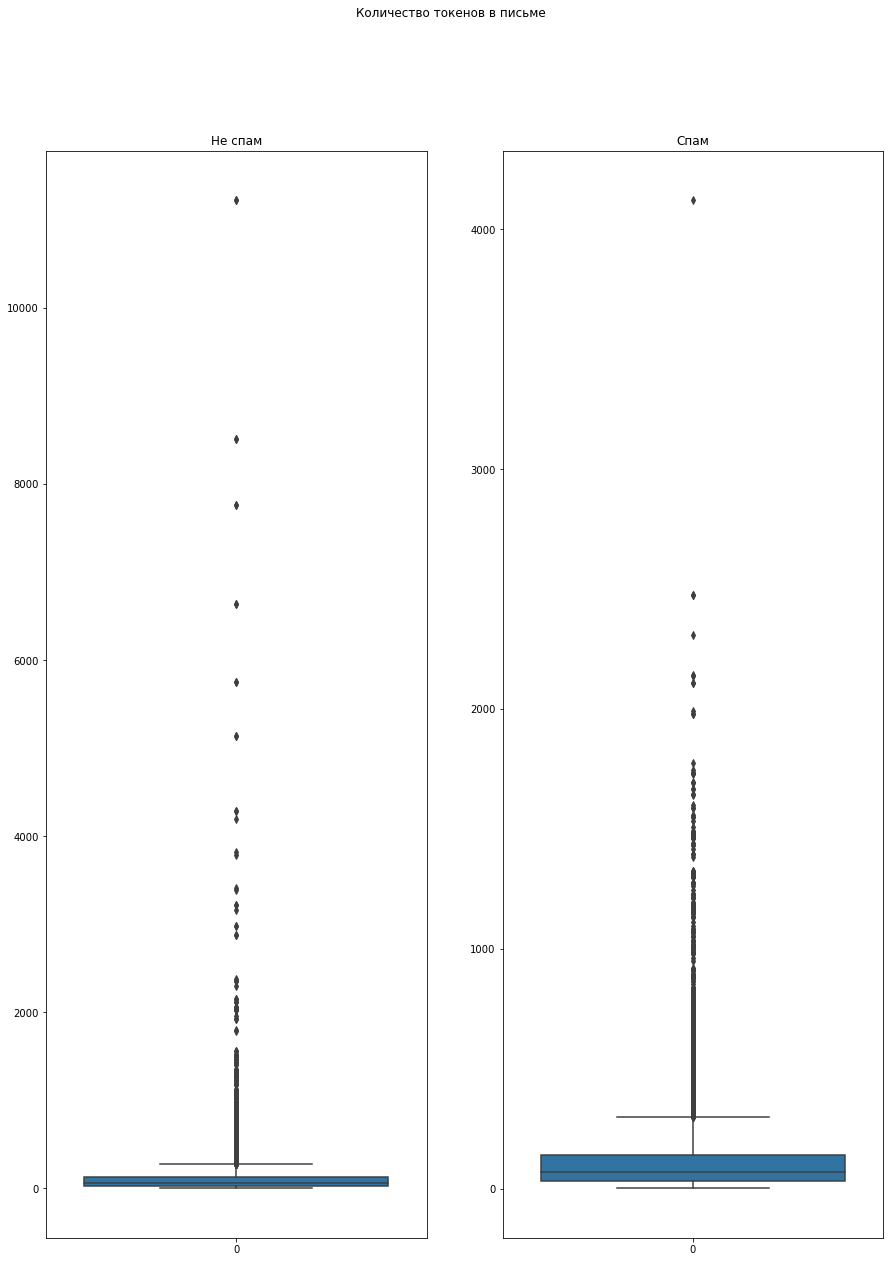

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 20))
sns.boxplot(data=data.loc[data.target == 0, 'token_count'].values, ax=axes[0])
sns.boxplot(data=data.loc[data.target == 1, 'token_count'].values, ax=axes[1])
axes[0].set_title('Не спам')
axes[1].set_title('Спам')
fig.suptitle('Количество токенов в письме')
plt.show()

* Посмотрим взаимодействие признаков

<AxesSubplot:>

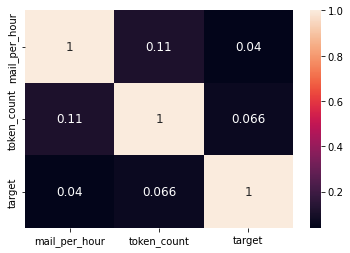

In [19]:
corr_matrix = data[['mail_per_hour', 'token_count', 'target']].corr(method='spearman')
corr_matrix

sns.heatmap(corr_matrix, annot=True, annot_kws={"size":12})

* Распределение писем в зависимости от дня недели (0 - понедельник)

<AxesSubplot:xlabel='day_week', ylabel='count'>

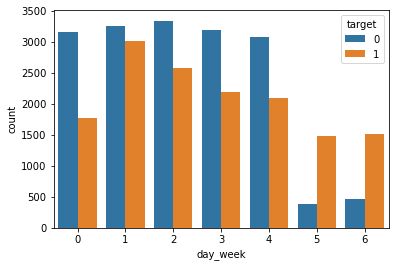

In [20]:
sns.countplot(x='day_week', hue='target', data=data)

* Распределение писем от временного периода

<AxesSubplot:xlabel='time_period', ylabel='count'>

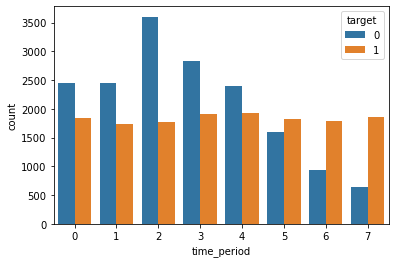

In [21]:
sns.countplot(x='time_period', hue='target', data=data)

* Распределение писем от наличия темы письма

<AxesSubplot:xlabel='have_subject', ylabel='count'>

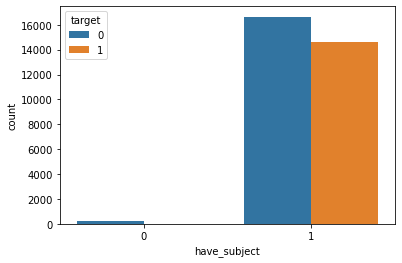

In [22]:
sns.countplot(x='have_subject', hue='target', data=data)

* Распределение писем от наличия тела письма

<AxesSubplot:xlabel='have_body', ylabel='count'>

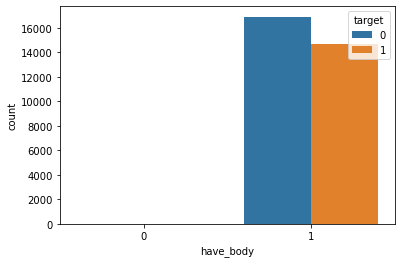

In [23]:
sns.countplot(x='have_body', hue='target', data=data)

Выводы: 

1. Между абсолютными признаками и целевой переменной нет линейной зависимости
2. Если пользователь отправил более 10 писем за час, то с большой вероятностью это спам
3. Есть зависимость от дня отправки письма
4. Есть зависимость от временного периода отправления письма

### Метрика качества и разделение набора данных

Для оценки моделей будем использовать метрику auc_roc

In [24]:
# модель, которая анализирует только текст
X = data['clean_content']

# комбинированные данные
X_comb = data[['mail_per_hour', 'token_count', 'day_week', 'time_period', 'have_subject', 'have_body', 'clean_content']]
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=SEED, shuffle=True, stratify=y)

X_comb_train, X_comb_test, y_comb_train, y_comb_test = train_test_split(X_comb, y, test_size=0.15, random_state=SEED, stratify=y)

In [25]:
X_train

25236    comput product sale comput shop network deliv ...
25493    comput product sale comput shop network deliv ...
8485     si server unavail today wednesday juli urgent ...
26922    full color postcard untitl document pure postc...
10779    thank use dear louis thank use submit registr ...
                               ...                        
1185     unit way time enron unit way campaign year the...
13716    talk u last sever year receiv numer question c...
30830    starv eat creami teen hi daddi hot erupt pusss...
9040     credit number repres approxim mm well optim un...
5583     ye sound great messag farmer daren sent monday...
Name: clean_content, Length: 26825, dtype: object

In [26]:
X_comb_train

,mail_per_hour,token_count,day_week,time_period,have_subject,have_body,clean_content
25236,11,46,5,1,1,1,comput product sale comput shop network deliv ...
25493,14,46,4,7,1,1,comput product sale comput shop network deliv ...
8485,1,98,2,3,1,1,si server unavail today wednesday juli urgent ...
26922,3,13,4,3,1,1,full color postcard untitl document pure postc...
10779,3,185,2,4,1,1,thank use dear louis thank use submit registr ...
...,...,...,...,...,...,...,...
1185,1,80,0,3,1,1,unit way time enron unit way campaign year the...
13716,1,142,2,4,1,1,talk u last sever year receiv numer question c...
30830,1,20,0,6,1,1,starv eat creami teen hi daddi hot erupt pusss...
9040,1,167,0,4,1,1,credit number repres approxim mm well optim un...


### Векторизация текста

#### TF-IDF

In [27]:
X_train_tfidf, X_test_tfidf = X_train, X_test

X_comb_train_tfidf, X_comb_test_tfidf = X_comb_train['clean_content'], X_comb_test['clean_content']

tfidf_vectorizer = TfidfVectorizer(lowercase=False, use_idf=True, sublinear_tf=True)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_tfidf.values.astype('str'))
X_test_tfidf = tfidf_vectorizer.transform(X_test_tfidf.values.astype('str'))

In [28]:
tfidf_vectorizer_comb = TfidfVectorizer(lowercase=False, use_idf=True, sublinear_tf=True)
X_comb_train_tfidf = tfidf_vectorizer_comb.fit_transform(X_comb_train_tfidf.values.astype('str'))
X_comb_test_tfidf = tfidf_vectorizer_comb.transform(X_comb_test_tfidf.values.astype('str'))

scaler = MinMaxScaler()  
X_comb_train_std = scaler.fit_transform(X_comb_train[['mail_per_hour', 'token_count', 'day_week', 'time_period', 'have_subject', 'have_body']])  
X_comb_test_std = scaler.transform(X_comb_test[['mail_per_hour', 'token_count', 'day_week', 'time_period', 'have_subject', 'have_body']])

X_comb_train_res = hstack([coo_matrix(X_comb_train_std), X_comb_train_tfidf])#.toarray()
X_comb_test_res = hstack([coo_matrix(X_comb_test_std), X_comb_test_tfidf])#.toarray()

In [29]:
X_comb_train_res

<26825x77965 sparse matrix of type '<class 'numpy.float64'>'
	with 2117658 stored elements in COOrdinate format>

### Обучение моделей

#### KNN

In [30]:
%%time
grid_params = {
    'n_neighbors': [x for x in range(5, 11)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_train_tfidf, y_train)

Wall time: 3min 2s


In [31]:
gs_results.best_params_

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

In [32]:
classifier = KNeighborsClassifier(n_neighbors=gs_results.best_params_['n_neighbors'], weights=gs_results.best_params_['weights'], metric='euclidean')  
classifier.fit(X_train_tfidf, y_train)  

y_pred_train = classifier.predict(X_train_tfidf) 
y_pred_test = classifier.predict(X_test_tfidf) 
y_prob_test = classifier.predict_proba(X_test_tfidf)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_KNN, tpr_KNN, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_KNN = metrics.auc(fpr_KNN, tpr_KNN)
print('\nAUC:', roc_auc_KNN)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2535
           1       0.98      0.98      0.98      2199

    accuracy                           0.98      4734
   macro avg       0.98      0.98      0.98      4734
weighted avg       0.98      0.98      0.98      4734

Матрица ошибок
[[2497   38]
 [  37 2162]]

AUC: 0.9983083578424118


#### Naive Bayes

In [33]:
%%time
classifier = MultinomialNB()  
classifier.fit(X_train_tfidf, y_train)  

y_pred_train = classifier.predict(X_train_tfidf) 
y_pred_test = classifier.predict(X_test_tfidf) 
y_prob_test = classifier.predict_proba(X_test_tfidf)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_NB, tpr_NB, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_NB = metrics.auc(fpr_NB, tpr_NB)
print('\nAUC:', roc_auc_NB)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2535
           1       0.99      0.97      0.98      2199

    accuracy                           0.98      4734
   macro avg       0.98      0.98      0.98      4734
weighted avg       0.98      0.98      0.98      4734

Матрица ошибок
[[2508   27]
 [  61 2138]]

AUC: 0.9988291253061953
Wall time: 132 ms


#### Decision tree

In [34]:
%%time
grid_params = {
    'max_depth': [x for x in range(1, 30)],
    'criterion': ['gini', 'entropy']
}

gs = GridSearchCV(
    DecisionTreeClassifier(random_state=SEED),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_train_tfidf, y_train)

Wall time: 8min 55s


In [35]:
gs_results.best_params_

{'criterion': 'entropy', 'max_depth': 25}

In [36]:
classifier = DecisionTreeClassifier(max_depth=gs_results.best_params_['max_depth'], criterion=gs_results.best_params_['criterion'], random_state=SEED)  
classifier.fit(X_train_tfidf, y_train)  

y_pred_train = classifier.predict(X_train_tfidf) 
y_pred_test = classifier.predict(X_test_tfidf) 
y_prob_test = classifier.predict_proba(X_test_tfidf)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_CART, tpr_CART, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_CART = metrics.auc(fpr_CART, tpr_CART)
print('\nAUC:', roc_auc_CART)

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2535
           1       0.91      0.97      0.94      2199

    accuracy                           0.94      4734
   macro avg       0.94      0.94      0.94      4734
weighted avg       0.94      0.94      0.94      4734

Матрица ошибок
[[2318  217]
 [  63 2136]]

AUC: 0.964085073634869


#### SVM

In [37]:
%%time
grid_params = {
    'C': [1], 
    'gamma': ['auto'],
    'kernel': ['linear']
}

gs = GridSearchCV(
    SVC(probability=True, random_state=SEED),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_train_tfidf, y_train)

Wall time: 23min 15s


In [38]:
gs_results.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}

In [39]:
classifier = SVC(C=gs_results.best_params_['C'], 
                 gamma=gs_results.best_params_['gamma'],
                 kernel=gs_results.best_params_['kernel'],
                 probability=True,
                 random_state=SEED)  
classifier.fit(X_train_tfidf, y_train)  

y_pred_train = classifier.predict(X_train_tfidf) 
y_pred_test = classifier.predict(X_test_tfidf) 
y_prob_test = classifier.predict_proba(X_test_tfidf)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_SVM, tpr_SVM, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_SVM = metrics.auc(fpr_SVM, tpr_SVM)
print('\nAUC:', roc_auc_SVM)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2535
           1       0.98      0.99      0.99      2199

    accuracy                           0.99      4734
   macro avg       0.99      0.99      0.99      4734
weighted avg       0.99      0.99      0.99      4734

Матрица ошибок
[[2501   34]
 [  15 2184]]

AUC: 0.9992649518832749


#### Random Forest

In [40]:
%%time
grid_params = {
    'n_estimators': [10, 20, 30, 40, 50],      
    'max_depth': [x for x in range(1, 11)],
    'criterion': ['gini', 'entropy']
}

gs = GridSearchCV(
    RandomForestClassifier(random_state=SEED, max_samples=0.66),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_train_tfidf, y_train)

Wall time: 3min 13s


In [41]:
gs_results.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 50}

In [42]:
classifier = RandomForestClassifier(n_estimators=gs_results.best_params_['n_estimators'], 
                                    max_depth=gs_results.best_params_['max_depth'],
                                    criterion=gs_results.best_params_['criterion'],
                                    random_state=SEED,
                                    max_samples=0.66)  
classifier.fit(X_train_tfidf, y_train)  

y_pred_train = classifier.predict(X_train_tfidf) 
y_pred_test = classifier.predict(X_test_tfidf) 
y_prob_test = classifier.predict_proba(X_test_tfidf)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_RF, tpr_RF, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_RF = metrics.auc(fpr_RF, tpr_RF)
print('\nAUC:', roc_auc_RF)

              precision    recall  f1-score   support

           0       0.81      0.99      0.89      2535
           1       0.99      0.74      0.85      2199

    accuracy                           0.87      4734
   macro avg       0.90      0.87      0.87      4734
weighted avg       0.90      0.87      0.87      4734

Матрица ошибок
[[2521   14]
 [ 578 1621]]

AUC: 0.988518987920814


#### Logistic regression

In [43]:
%%time
grid_params = {
    'C': np.logspace(-3, 3, 7), 
    'penalty': ['l1', 'l2']
}

gs = GridSearchCV(
    LogisticRegression(random_state=SEED),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_train_tfidf, y_train)

Wall time: 29.5 s


In [44]:
gs_results.best_params_

{'C': 100.0, 'penalty': 'l2'}

In [45]:
classifier = LogisticRegression(C=gs_results.best_params_['C'], 
                                penalty=gs_results.best_params_['penalty'],
                                random_state=SEED)  
classifier.fit(X_train_tfidf, y_train)  

y_pred_train = classifier.predict(X_train_tfidf) 
y_pred_test = classifier.predict(X_test_tfidf) 
y_prob_test = classifier.predict_proba(X_test_tfidf)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_LR, tpr_LR, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_LR = metrics.auc(fpr_LR, tpr_LR)
print('\nAUC:', roc_auc_LR)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2535
           1       0.99      0.99      0.99      2199

    accuracy                           0.99      4734
   macro avg       0.99      0.99      0.99      4734
weighted avg       0.99      0.99      0.99      4734

Матрица ошибок
[[2509   26]
 [  16 2183]]

AUC: 0.9994128584536811


### Обучение моделей с комбинированными данными

#### KNN

In [46]:
%%time
grid_params = {
    'n_neighbors': [x for x in range(5, 11)],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_comb_train_res, y_train)
print(gs_results.best_params_)

classifier = KNeighborsClassifier(n_neighbors=gs_results.best_params_['n_neighbors'], weights=gs_results.best_params_['weights'], metric='euclidean')  
classifier.fit(X_comb_train_res, y_train)  

y_pred_train = classifier.predict(X_comb_train_res) 
y_pred_test = classifier.predict(X_comb_test_res) 
y_prob_test = classifier.predict_proba(X_comb_test_res)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_KNNc, tpr_KNNc, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_KNNc = metrics.auc(fpr_KNNc, tpr_KNNc)
print('\nAUC:', roc_auc_KNNc)

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2535
           1       0.98      0.98      0.98      2199

    accuracy                           0.98      4734
   macro avg       0.98      0.98      0.98      4734
weighted avg       0.98      0.98      0.98      4734

Матрица ошибок
[[2495   40]
 [  47 2152]]

AUC: 0.9980386458610826
Wall time: 4min 51s


#### Naive Bayes

In [47]:
%%time
classifier = MultinomialNB()  
classifier.fit(X_comb_train_res, y_train)  

y_pred_train = classifier.predict(X_comb_train_res) 
y_pred_test = classifier.predict(X_comb_test_res) 
y_prob_test = classifier.predict_proba(X_comb_test_res)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_NBc, tpr_NBc, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_NBc = metrics.auc(fpr_NBc, tpr_NBc)
print('\nAUC:', roc_auc_NBc)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2535
           1       0.99      0.97      0.98      2199

    accuracy                           0.98      4734
   macro avg       0.98      0.98      0.98      4734
weighted avg       0.98      0.98      0.98      4734

Матрица ошибок
[[2512   23]
 [  63 2136]]

AUC: 0.9988391711132817
Wall time: 484 ms


#### Decision tree

In [48]:
%%time
grid_params = {
    'max_depth': [x for x in range(1, 30)],
    'criterion': ['gini', 'entropy']
}

gs = GridSearchCV(
    DecisionTreeClassifier(random_state=SEED),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_comb_train_res, y_train)
print(gs_results.best_params_)

classifier = DecisionTreeClassifier(max_depth=gs_results.best_params_['max_depth'], criterion=gs_results.best_params_['criterion'], random_state=SEED)  
classifier.fit(X_comb_train_res, y_train)  

y_pred_train = classifier.predict(X_comb_train_res) 
y_pred_test = classifier.predict(X_comb_test_res) 
y_prob_test = classifier.predict_proba(X_comb_test_res)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_CARTc, tpr_CARTc, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_CARTc = metrics.auc(fpr_CARTc, tpr_CARTc)
print('\nAUC:', roc_auc_CARTc)

{'criterion': 'entropy', 'max_depth': 25}
              precision    recall  f1-score   support

           0       0.98      0.92      0.94      2535
           1       0.91      0.97      0.94      2199

    accuracy                           0.94      4734
   macro avg       0.94      0.94      0.94      4734
weighted avg       0.94      0.94      0.94      4734

Матрица ошибок
[[2323  212]
 [  59 2140]]

AUC: 0.9710065450227062
Wall time: 10min 30s


#### SVM

In [49]:
%%time
grid_params = {
    'C': [1], 
    'gamma': ['auto'],
    'kernel': ['linear']
}

gs = GridSearchCV(
    SVC(probability=True, random_state=SEED),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_comb_train_res, y_train)
print(gs_results.best_params_)

classifier = SVC(C=gs_results.best_params_['C'], 
                 gamma=gs_results.best_params_['gamma'],
                 kernel=gs_results.best_params_['kernel'],
                 probability=True,
                 random_state=SEED)  
classifier.fit(X_comb_train_res, y_train)  

y_pred_train = classifier.predict(X_comb_train_res) 
y_pred_test = classifier.predict(X_comb_test_res) 
y_prob_test = classifier.predict_proba(X_comb_test_res)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_SVMc, tpr_SVMc, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_SVMc = metrics.auc(fpr_SVMc, tpr_SVMc)
print('\nAUC:', roc_auc_SVMc)

{'C': 1, 'gamma': 'auto', 'kernel': 'linear'}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2535
           1       0.99      0.99      0.99      2199

    accuracy                           0.99      4734
   macro avg       0.99      0.99      0.99      4734
weighted avg       0.99      0.99      0.99      4734

Матрица ошибок
[[2504   31]
 [  12 2187]]

AUC: 0.9994856905550578
Wall time: 36min 35s


#### Random Forest

In [50]:
%%time
grid_params = {
    'n_estimators': [10, 20, 30, 40, 50],      
    'max_depth': [x for x in range(1, 11)],
    'criterion': ['gini', 'entropy']
}

gs = GridSearchCV(
    RandomForestClassifier(random_state=SEED, max_samples=0.66),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_comb_train_res, y_train)
print(gs_results.best_params_)

classifier = RandomForestClassifier(n_estimators=gs_results.best_params_['n_estimators'], 
                                    max_depth=gs_results.best_params_['max_depth'],
                                    criterion=gs_results.best_params_['criterion'],
                                    random_state=SEED,
                                    max_samples=0.66)  
classifier.fit(X_comb_train_res, y_train)  

y_pred_train = classifier.predict(X_comb_train_res) 
y_pred_test = classifier.predict(X_comb_test_res) 
y_prob_test = classifier.predict_proba(X_comb_test_res)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_RFc, tpr_RFc, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_RFc = metrics.auc(fpr_RFc, tpr_RFc)
print('\nAUC:', roc_auc_RFc)

{'criterion': 'gini', 'max_depth': 10, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       0.84      0.99      0.91      2535
           1       0.99      0.79      0.88      2199

    accuracy                           0.90      4734
   macro avg       0.91      0.89      0.89      4734
weighted avg       0.91      0.90      0.89      4734

Матрица ошибок
[[2511   24]
 [ 469 1730]]

AUC: 0.9897125553752693
Wall time: 3min 35s


#### Logistic regression

In [51]:
%%time
grid_params = {
    'C': np.logspace(-3, 3, 7), 
    'penalty': ['l1', 'l2']
}

gs = GridSearchCV(
    LogisticRegression(random_state=SEED),
    grid_params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=5
)

gs_results = gs.fit(X_comb_train_res, y_train)
print(gs_results.best_params_)

classifier = LogisticRegression(C=gs_results.best_params_['C'], 
                                penalty=gs_results.best_params_['penalty'],
                                random_state=SEED)  
classifier.fit(X_comb_train_res, y_train)  

y_pred_train = classifier.predict(X_comb_train_res) 
y_pred_test = classifier.predict(X_comb_test_res) 
y_prob_test = classifier.predict_proba(X_comb_test_res)[:,1]

print(classification_report(y_test, y_pred_test))
print('Матрица ошибок')
print(confusion_matrix(y_test, y_pred_test))
 
fpr_LRc, tpr_LRc, thresholds = metrics.roc_curve(y_test, y_prob_test)
roc_auc_LRc = metrics.auc(fpr_LRc, tpr_LRc)
print('\nAUC:', roc_auc_LRc)

{'C': 100.0, 'penalty': 'l2'}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2535
           1       0.99      0.99      0.99      2199

    accuracy                           0.99      4734
   macro avg       0.99      0.99      0.99      4734
weighted avg       0.99      0.99      0.99      4734

Матрица ошибок
[[2512   23]
 [  12 2187]]

AUC: 0.9995242592786932
Wall time: 39.4 s


### Результаты

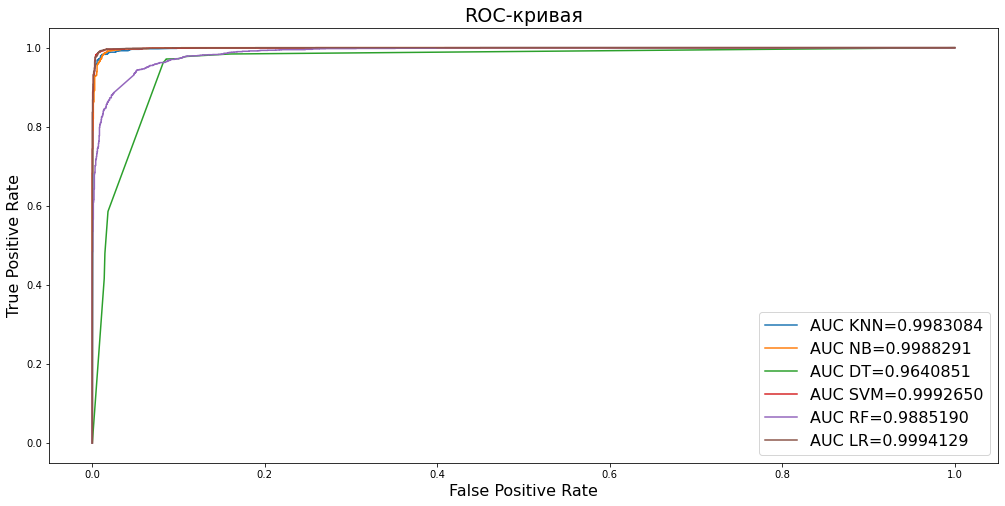

In [52]:
fig, axes = plt.subplots(figsize=(17, 8))
plt.plot(fpr_KNN, tpr_KNN, label=f'AUC KNN={roc_auc_KNN:.7f}')
plt.plot(fpr_NB, tpr_NB, label=f'AUC NB={roc_auc_NB:.7f}')
plt.plot(fpr_CART, tpr_CART, label=f'AUC DT={roc_auc_CART:.7f}')
plt.plot(fpr_SVM, tpr_SVM, label=f'AUC SVM={roc_auc_SVM:.7f}')
plt.plot(fpr_RF, tpr_RF, label=f'AUC RF={roc_auc_RF:.7f}')
plt.plot(fpr_LR, tpr_LR, label=f'AUC LR={roc_auc_LR:.7f}')
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
axes.set_title('ROC-кривая', fontsize=19)
plt.legend(loc=4, fontsize=16)
plt.show()

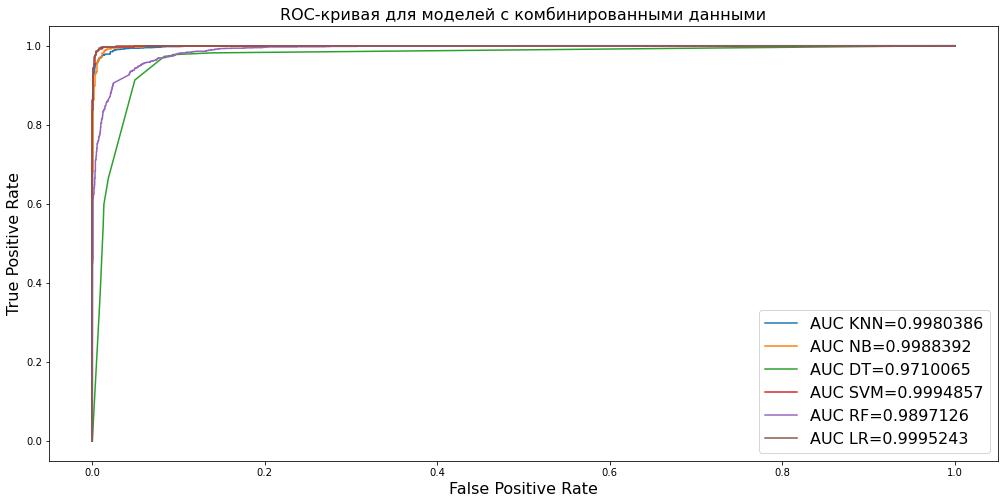

In [53]:
fig, axes = plt.subplots(figsize=(17, 8))
plt.plot(fpr_KNNc, tpr_KNNc, label=f'AUC KNN={roc_auc_KNNc:.7f}')
plt.plot(fpr_NBc, tpr_NBc, label=f'AUC NB={roc_auc_NBc:.7f}')
plt.plot(fpr_CARTc, tpr_CARTc, label=f'AUC DT={roc_auc_CARTc:.7f}')
plt.plot(fpr_SVMc, tpr_SVMc, label=f'AUC SVM={roc_auc_SVMc:.7f}')
plt.plot(fpr_RFc, tpr_RFc, label=f'AUC RF={roc_auc_RFc:.7f}')
plt.plot(fpr_LRc, tpr_LRc, label=f'AUC LR={roc_auc_LRc:.7f}')
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=16)
axes.set_title('ROC-кривая для моделей с комбинированными данными', fontsize=16)
plt.legend(loc=4, fontsize=16)
plt.show()

На графиках изображены roc-кривые и значения auc для всех алгоритмов классификации. Их расположение относительно друг друга указывает на эффективность алгоритма. Кривая, которая расположена левее и выше, указывает на большую предсказательную силу модели. Из графиков видно, что алгоритмы логистическая регрессия и метод опорных векторов показали лучшие результаты. 

Добавление признаков улучшает работу 5 алгоритмов из 6. Скорее всего, качество метода ближайших соседей упало из-за наличия неинформативных переменных.

### Выводы

Таким образом, спам остается важной проблемой, с которой регулярно сталкивается пользователь. В данной работе, используя размеченный набор данных, который состоял из 31715 объектов, было показано, что алгоритмы машинного обучения показывают высокую точность в задаче обнаружения спама. Лучшую точность показали два алгоритма: метод опорных векторов и логистическая регрессия. Значения метрики auc равны 0,999. Также в работе было показано, что использование метаданных письма позволяет повысить качество работы алгоритмов. Для повышения качества были использованы следующие сгенерированные признаки: количество писем отправленных за час, количество токенов в контенте письма, день недели, временной промежуток, наличие темы и тела письма. 

В данной работе уже была получена высокая точность классификации, однако существует ряд методов, которые могут еще улучшить качество. Например, для векторизации текста можно попробовать использовать предобученные вектора Word2vec. Также же можно попробовать применить нейронные сети например, BERT. 
